# This is the first baseline model of the MRI Thesis

## Setting up the Google Drive

In [1]:
## Loading the google drive where I stored the MOSMEDDATA files
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
toTrain_path = '/content/drive/MyDrive/Colab Notebooks/Data/Second_Dataset'
toPredict_path = '/content/drive/MyDrive/Colab Notebooks/Data/Second_Dataset'

toTrain_path_output = '/content/drive/MyDrive/Colab Notebooks/Data/Second_Dataset/output_v2'
toPredict_path_output = '/content/drive/MyDrive/Colab Notebooks/Data/Second_Dataset/output_v2'

### Sectioning off some of the data for prediction

In [3]:
## A tool for spliting the image files before processing
!pip install split-folders
import splitfolders

## 80/20 Split of the data
splitfolders.ratio(toTrain_path, output=toTrain_path_output, seed=1337, ratio=(0.95, 0.05))
splitfolders.ratio(toPredict_path, output=toPredict_path_output, seed=1337, ratio=(0.95, 0.05))

Copying files: 126 files [03:43,  1.77s/ files]
Copying files: 126 files [00:22,  5.61 files/s]


In [4]:
import os

## Alzheimers Files
path, dirs, files = next(os.walk(toTrain_path_output + '/train/AD'))
file_count = len(files)
file_count

63

In [5]:
## Normal Control Files
path, dirs, files = next(os.walk(toTrain_path_output + '/train/NC'))
file_count = len(files)
file_count

56

In [6]:
import numpy as np
import nibabel as nib
from nibabel.testing import data_path
from scipy import ndimage

In [7]:
## Read Function
def read_NifTi(fp):
    scan = nib.load(fp)
    scan = scan.get_fdata()
    return scan

## Resize function
def resizeVolume(img):

    ## desired
    d_depth = 64
    d_width = 224
    d_height = 224

    ## current
    c_depth = img.shape[-1]
    c_width = img.shape[0]
    c_height = img.shape[1]

    ## factor to change by
    d_factor = d_depth/c_depth
    w_factor = d_width/c_width
    h_factor = d_height/c_height

    ## Adjust proper rotation
    img = ndimage.rotate(img, 90, reshape = False)

    ## apply the factors
    img = ndimage.zoom(img, (w_factor, h_factor, d_factor), order = 1)

    return img
  
## Normalize Function
def normalizeVolume(vol):
    min = -1000
    max = 400
    vol[vol < min] = min
    vol[vol > max] = max
    vol = (vol - min) / (max - min)
    vol = vol.astype("float32")
    return vol

## Processing Function
def processVolume(path):
    volume = read_NifTi(path)
    volume = normalizeVolume(volume)
    volume = resizeVolume(volume)
    return volume

In [8]:
## Setting up the filepaths for each file in NC
normal_scan_paths = [
    os.path.join(os.getcwd(), toTrain_path_output + '/train/NC', x)
    for x in os.listdir(toTrain_path_output + '/train/NC')
]

## Setting up the filepaths for each file in class 2
alzheimer_scan_paths = [
    os.path.join(os.getcwd(), toTrain_path_output + '/train/AD', x)
    for x in os.listdir(toTrain_path_output + '/train/AD')
]

In [9]:
## Normal Subject files into numpy arrays
normal_volumes = np.array([processVolume(path) for path in normal_scan_paths])
normal_volume_labels = np.array([0 for _ in range(len(normal_volumes))])

In [10]:
## Alzheimer's Subject files into numpy arrays
alzheimer_volumes = np.array([processVolume(path) for path in alzheimer_scan_paths])
alzheimer_volume_labels = np.array([1 for _ in range(len(alzheimer_volumes))])

In [11]:
print("MRI scans with normal neuro presentation: " + str(len(normal_scan_paths)))
print("MRI scans with abnormal alzheimner's presentation: " + str(len(alzheimer_scan_paths)))

MRI scans with normal neuro presentation: 56
MRI scans with abnormal alzheimner's presentation: 63


In [ ]:
## 60/20 Split of volumes
X_train = np.concatenate((alzheimer_volumes[:50], normal_volumes[:50]), axis=0)
y_train = np.concatenate((alzheimer_volume_labels[:50], normal_volume_labels[:50]), axis=0)

X_val = np.concatenate((alzheimer_volumes[50:], normal_volumes[50:]), axis=0)
y_val = np.concatenate((alzheimer_volume_labels[50:], normal_volume_labels[50:]), axis=0)

print(   
"Number of samples in train and validation are %d and %d."
    % (X_train.shape[0], X_val.shape[0])
)
X_train.shape

Number of samples in train and validation are 100 and 19.


(100, 224, 224, 64)

### Preprocessing Directives

In [ ]:
import random
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
## Rotation Augmentation
def rotate(volume):

    def scipy_rotate(volume):
        # define some rotation angles
        angles = [-20, -10, -5, 5, 10, 20]
        # pick angles at random
        angle = random.choice(angles)
        # rotate volume
        volume = ndimage.rotate(volume, angle, reshape=False)
        volume[volume < 0] = 0
        volume[volume > 1] = 1
        return volume

    augmented_volume = tf.numpy_function(scipy_rotate, [volume], tf.float32)
    return augmented_volume

In [ ]:
## For now we will not do preprocessing
## Only add the the stack to match dimensionality

def train_preprocess(volume, label):
  # volume = rotate(volume)
  volume = tf.stack((volume,)*3, axis = 3)
  return volume, label
def valid_preprocess(volume, label):
  volume = tf.stack((volume,)*3, axis = 3)
  return volume, label

In [ ]:
## Run the preprocessing Steps
X_train_r, y_train_r = train_preprocess(X_train, y_train)
X_val_r, y_val_r = valid_preprocess(X_val, y_val)

## Taking away the top and bottom pictures so that there are no blacked out
### This will allow the model to pick up on real patterns reather than just
### useless information about non-functional data

In [ ]:
numImagesPerVoxel = 40

In [ ]:
## Slicing Function
def threeDToTwoD(threeDVol, numVol, numImages):

  twoDVol = np.zeros((numVol*numImages, 224, 224, 3), np.float32)

  count = 0

  for i in range(numVol):
    for j in range(12,52):
      twoDVol[count] = threeDVol[i,:,:,:,j]
      count = count + 1

  return twoDVol

### Here i realized that this was not accounting for the y labels correctly
### Therefore I added the numImages

In [ ]:
## Extending Labels to Match
def extendLabels(labelArr, numVol, numImages):

  newLabelArr = np.zeros((numVol * numImages), np.float32)

  for i in range(numVol):
    for j in range(numImages):
      newLabelArr[(i*numImages)+j] = labelArr[i]

  return newLabelArr

In [ ]:
len(y_train_r)

100

In [ ]:
len(y_val_r)

19

In [ ]:
## New arrays

## First the training images
X_train_f = threeDToTwoD(X_train_r, len(X_train_r), numImagesPerVoxel)

## Second the validation images
X_val_f = threeDToTwoD(X_val_r, len(X_val_r), numImagesPerVoxel)

## Third the training labels
y_train_f = extendLabels(y_train_r, len(y_train_r), numImagesPerVoxel)

## Fourth the validation labels
y_val_f = extendLabels(y_val_r, len(y_val_r), numImagesPerVoxel)

In [ ]:
X_train_f.shape

(4000, 224, 224, 3)

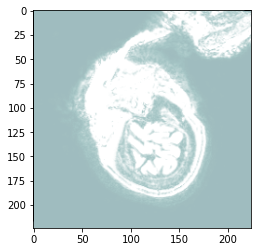

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(X_train_f[40,:,:,2],cmap='bone')

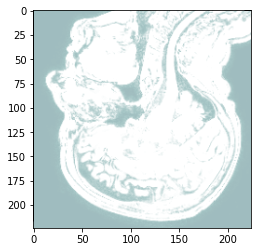

In [ ]:
plt.imshow(X_train_f[3100,:,:,0],cmap='bone')

### Now the model

In [ ]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv3D, MaxPooling3D, Dropout, BatchNormalization
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
data_augmentation = tf.keras.Sequential(
    [layers.RandomFlip("horizontal"), layers.RandomRotation(0.1),])

In [ ]:
## The model build
def buildModel():

  initial_model = tf.keras.applications.VGG19(
      weights = 'imagenet',
      input_shape = (224,224,3),
      include_top = False)
  
  ## Freeze the pretrained model parameters
  initial_model.trainable = False

  inputs = tf.keras.Input(shape = (224,224,3))

  x = data_augmentation(inputs)

  scale_layer = tf.keras.layers.Rescaling(scale=1 / 127.5, offset=-1)
  x = scale_layer(x)

  x = initial_model(inputs, training = False)
  x = tf.keras.layers.GlobalAveragePooling2D()(x)
  outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

  model = tf.keras.Model(inputs, outputs)
  return model

model = buildModel()
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 global_average_pooling2d_3   (None, 512)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_3 (Dense)             (None, 1)                 513       
                                                                 
Total params: 20,024,897
Trainable params: 513
Non-trainable params: 20,024,384
_________________________________________________________________


In [ ]:
## Setting up the fit parameters
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    0.001, decay_steps=100000, decay_rate=0.96, staircase=True
)

model.compile(loss = tf.keras.losses.BinaryCrossentropy(),
              optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule),
              metrics = tf.keras.metrics.BinaryAccuracy(),
              )

## Defining checkpoints
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    "3D_CT_classification.h5", save_best_only=True
)
early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)

## How man runs
epochs = 50

In [ ]:
## Training the model
history = model.fit(x = X_train_f,
                    y = y_train_f,
                    validation_data=(X_val_f, y_val_f),
                    epochs=epochs,
                    shuffle=True,
                    verbose='auto',
                    callbacks = [ checkpoint_cb , early_stopping_cb],
                    )

Epoch 1/50
125/125 [==============================] - 12s 95ms/step - loss: 0.6930 - binary_accuracy: 0.5157 - val_loss: 0.6886 - val_binary_accuracy: 0.5329
Epoch 2/50
125/125 [==============================] - 11s 91ms/step - loss: 0.6818 - binary_accuracy: 0.5813 - val_loss: 0.6723 - val_binary_accuracy: 0.6395
Epoch 3/50
125/125 [==============================] - 11s 90ms/step - loss: 0.6753 - binary_accuracy: 0.5943 - val_loss: 0.6939 - val_binary_accuracy: 0.4934
Epoch 4/50
125/125 [==============================] - 11s 89ms/step - loss: 0.6668 - binary_accuracy: 0.6137 - val_loss: 0.6766 - val_binary_accuracy: 0.5776
Epoch 5/50
125/125 [==============================] - 11s 89ms/step - loss: 0.6610 - binary_accuracy: 0.6202 - val_loss: 0.6931 - val_binary_accuracy: 0.4987
Epoch 6/50
125/125 [==============================] - 11s 90ms/step - loss: 0.6543 - binary_accuracy: 0.6280 - val_loss: 0.7169 - val_binary_accuracy: 0.4632
Epoch 7/50
125/125 [==============================] 

In [ ]:
# Calling `save('my_model')` creates a SavedModel folder `my_model`.
model.save("/content/drive/MyDrive/Colab Notebooks/MRI_model_v3")

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/MRI_model_v3/assets


## Loading the model and predicting here

In [ ]:
from tensorflow import keras
reloaded_model = keras.models.load_model("/content/drive/MyDrive/Colab Notebooks/MRI_model_v3")

## Here we will take a look at a visualization of the model.

In [ ]:
!pip3 install visualkeras

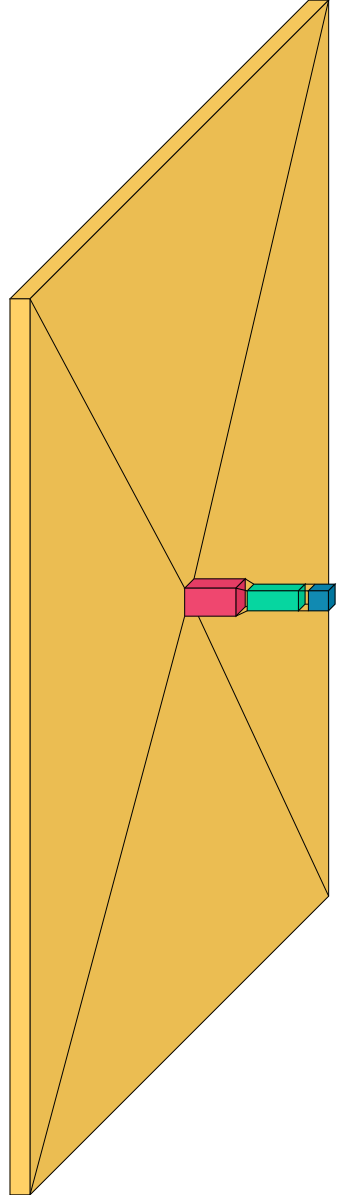

In [ ]:
## Using visualkeras
import visualkeras
visualkeras.layered_view(reloaded_model).show()
visualkeras.layered_view(reloaded_model)

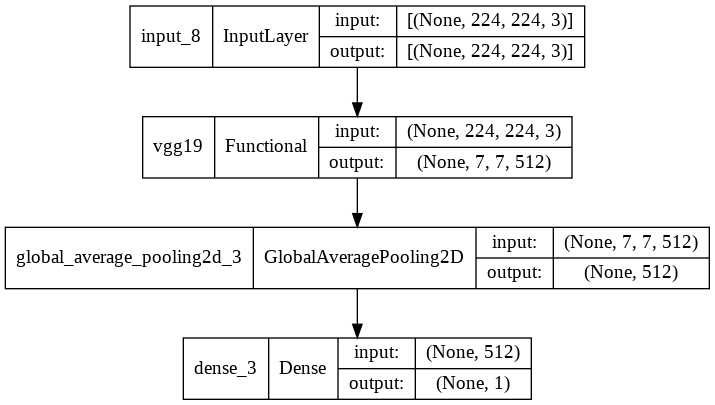

In [ ]:
## Using the keras visualizer
tf.keras.utils.plot_model(reloaded_model, show_shapes=True)

In [ ]:
print(history.history.keys())

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])


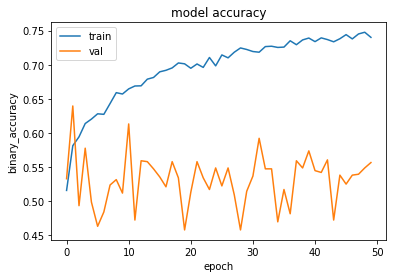

In [ ]:
## Showing the accuracy as a graph for easier viewing
import matplotlib.pyplot as plt

plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('model accuracy')
plt.ylabel('binary_accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

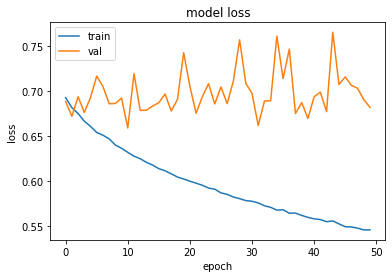

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## Now to predict some and collec the stats

In [ ]:
## Alzheimers Files
path, dirs, files = next(os.walk(toPredict_path_output + '/val/AD'))
file_count = len(files)
print(file_count)

## Normal Control Files
path, dirs, files = next(os.walk(toPredict_path_output + '/val/NC'))
file_count = len(files)
print(file_count)

4
3


In [ ]:
## Setting up the filepaths for each file in NC
predict_normal_scan_paths = [
    os.path.join(os.getcwd(), toPredict_path_output + '/val/NC', x)
    for x in os.listdir(toPredict_path_output + '/val/NC')
]

## Setting up the filepaths for each file in class 2
predict_alzheimer_scan_paths = [
    os.path.join(os.getcwd(), toPredict_path_output + '/val/AD', x)
    for x in os.listdir(toPredict_path_output + '/val/AD')
]

In [ ]:
## Normal Subject files into numpy arrays
predict_normal_volumes = np.array([processVolume(path) for path in predict_normal_scan_paths])
predict_normal_volume_labels = np.array([0 for _ in range(len(predict_normal_volumes))])

## Alzheimer's Subject files into numpy arrays
predict_alzheimer_volumes = np.array([processVolume(path) for path in predict_alzheimer_scan_paths])
predict_alzheimer_volume_labels = np.array([1 for _ in range(len(predict_alzheimer_volumes))])

print("MRI scans with normal neuro presentation: " + str(len(predict_normal_scan_paths)))
print("MRI scans with abnormal alzheimner's presentation: " + str(len(predict_alzheimer_scan_paths)))

MRI scans with normal neuro presentation: 3
MRI scans with abnormal alzheimner's presentation: 4


In [ ]:
## Setting up the X and Y for predictions
X_predict = np.concatenate((predict_normal_volumes, predict_alzheimer_volumes), axis=0)
y_predict = np.concatenate((predict_normal_volume_labels, predict_alzheimer_volume_labels), axis=0)

In [ ]:
## Applying the same RGB fix
X_predict_r, y_predict_r = train_preprocess(X_predict, y_predict)
print(X_predict_r.shape)
print(y_predict_r.shape)

(7, 224, 224, 3, 64)
(7,)


In [ ]:
len(X_predict)

7

In [ ]:
## Second the validation images
X_predict_f = threeDToTwoD(X_predict_r, len(X_predict),numImagesPerVoxel)

## Third the training labels
y_predict_f = extendLabels(y_predict_r, len(y_predict),numImagesPerVoxel)

In [ ]:
## Doing the predictions and getting the metrics
prediction = reloaded_model.predict(X_predict_f)

loss, metrics = reloaded_model.evaluate(X_predict_f, y_predict_f)

9/9 [==============================] - 1s 75ms/step - loss: 0.6160 - binary_accuracy: 0.6786


In [ ]:
!pip3 install -U scikit-learn


In [ ]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_predict_f, prediction)


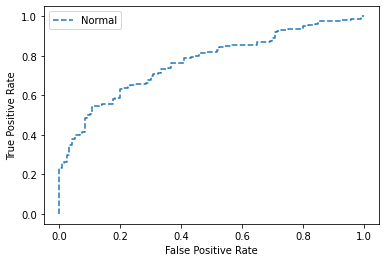

In [ ]:
from matplotlib import pyplot

pyplot.plot(fpr, tpr, linestyle='--', label='Normal')
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend()
pyplot.show()

In [ ]:
## Displaying Predictions
print(prediction)
print(loss)
print(metrics)

[[0.45076585]
 [0.30979592]
 [0.5889428 ]
 [0.48496914]
 [0.31018808]
 [0.3113993 ]
 [0.3417953 ]
 [0.27771285]
 [0.43820247]
 [0.3978198 ]
 [0.43639487]
 [0.40384015]
 [0.38210097]
 [0.36471373]
 [0.4063796 ]
 [0.57155794]
 [0.4982058 ]
 [0.28907737]
 [0.4564275 ]
 [0.3571541 ]
 [0.3583355 ]
 [0.268847  ]
 [0.27517232]
 [0.4002888 ]
 [0.41482174]
 [0.31720576]
 [0.2772738 ]
 [0.25324023]
 [0.2440587 ]
 [0.27974835]
 [0.30198526]
 [0.28694603]
 [0.3683488 ]
 [0.45495117]
 [0.49811155]
 [0.56161404]
 [0.5337899 ]
 [0.6270318 ]
 [0.50974715]
 [0.5012494 ]
 [0.35473928]
 [0.30081108]
 [0.31553343]
 [0.31458014]
 [0.2988378 ]
 [0.34331122]
 [0.22614431]
 [0.22951384]
 [0.31429794]
 [0.36871737]
 [0.30364025]
 [0.50667465]
 [0.3908496 ]
 [0.4233749 ]
 [0.46271548]
 [0.5204101 ]
 [0.5519627 ]
 [0.48491082]
 [0.34521136]
 [0.45446452]
 [0.49282876]
 [0.36460397]
 [0.4504798 ]
 [0.40000114]
 [0.4288864 ]
 [0.5529004 ]
 [0.508167  ]
 [0.41926065]
 [0.3186782 ]
 [0.28460205]
 [0.18611263]
 [0.29